# Monte Carlo in spinfoams

Description of the notebook

## Setup

In [1]:
# set Plot style
using Plots
using Plots.PlotMeasures
using LaTeXStrings

# set backend and style
pgfplotsx()
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    linewidth = 2,
    grid = :true,
    gridlinewidth = 0.5,
    markersize = 5,
    tickfontsize = 22,
    size = (900, 600),
    legendfontsize = 22,
    guidefontsize = 22,
    titlefontsize = 22,
    legend = (0.03, 0.98),
    foreground_color_axis = "black",
    foreground_color_border = "black",
    foreground_color_guide = "darkorange",
    foreground_color_text = "black",
    guidefontcolor = "black",
    plot_titlefontcolor = "black",
    titlefontcolor = "black",
    shape = [:circle],
    markershape = [:circle],
)

In [2]:
using CSV
using DataFrames

Simple Dict to remember how the float $\mu$ are represented in the data directory structure

In [3]:
MU = Dict([
    (2/6, 0.333), 
    (1, 1.0),
    (7/6, 1.167),
    (8/6,1.333)]) 

Dict{Real, Float64} with 4 entries:
  0.333333 => 0.333
  1.33333  => 1.333
  1.16667  => 1.167
  1        => 1.0

In [4]:
using Statistics

## Loading Data

Define the base paths where the data is stored

In [5]:
DIAGRAM = "self_energy";
BASE_DATA_DIRECTORY = "../../data";
MODEL = "EPRL";

Function to load a dataframe given the number of Monte Carlo sampling `Nmc`, the face weight $\mu$ `mu`, the boundary intertwiner `ib`, and the trial number `trial`

In [6]:
function get_data(Nmc, mu, ib, Dl, trial)
    DataFrame(
            CSV.File(
                "$(BASE_DATA_DIRECTORY)/$(DIAGRAM)/jb_0.5/monte_carlo/Nmc_$(Nmc)/$(MODEL)/immirzi_0.1/Dl_$(Dl)/weight_$(mu)/ib_$(ib)/ampls_cutoff_10_trial_$(trial).csv",
            ),
        )
end


get_data (generic function with 1 method)

# Study $\mu=1$ first

In [ ]:
function extrapolate(AaDL,AaDLm1,AaDLm2)
    num = AaDL * AaDLm2 - AaDLm1^2 
    den = AaDL  - 2* AaDLm1 + AaDLm2
    num/den
end

extrapolate (generic function with 1 method)

In [ ]:
function get_data_alltrials(Nmc, mu, ib, Dl)
    amp_df = DataFrame()
    std_df = DataFrame()
    for trial in 1:10
        dftmp = get_data(Nmc,mu,ib, Dl, trial)
        amp_df[!,"trial$(trial)"] = dftmp.amp
        std_df[!,"trial$(trial)"] = dftmp.std
    end
    amp_df, std_df
end

get_data_alltrials (generic function with 1 method)

In [ ]:
amp_100K_1_DL10 , std_100K_1_DL10 = get_data_alltrials(100000,MU[1],0,10);
amp_100K_1_DL9  , std_100K_1_DL9  = get_data_alltrials(100000,MU[1],0,9);
amp_100K_1_DL8  , std_100K_1_DL8  = get_data_alltrials(100000,MU[1],0,8);

means_100K_1_DL10 = [mean(ampl) for ampl in eachrow(amp_100K_1_DL10)][2:end];
stds_100K_1_DL10  = [std(ampl)  for ampl in eachrow(amp_100K_1_DL10)][2:end];

means_100K_1_DL9 = [mean(ampl) for ampl in eachrow(amp_100K_1_DL9)][2:end];
stds_100K_1_DL9  = [std(ampl)  for ampl in eachrow(amp_100K_1_DL9)][2:end];

means_100K_1_DL8 = [mean(ampl) for ampl in eachrow(amp_100K_1_DL8)][2:end];
stds_100K_1_DL8  = [std(ampl)  for ampl in eachrow(amp_100K_1_DL8)][2:end];

amp_100K_1_extrapolation = DataFrame()
for trial in 1:10
    tmpdf = DataFrame([amp_100K_1_DL10[!,"trial$(trial)"],amp_100K_1_DL9[!,"trial$(trial)"],amp_100K_1_DL8[!,"trial$(trial)"]],["DL10","DL9","DL8"])
    amp_100K_1_extrapolation[!,"trial$(trial)"] = [extrapolate(ampl.DL10,ampl.DL9,ampl.DL8) for ampl in eachrow(tmpdf)];
end

means_100K_1_extrapolation = [mean(ampl) for ampl in eachrow(amp_100K_1_extrapolation)][2:end];
stds_100K_1_extrapolation  = [std(ampl)  for ampl in eachrow(amp_100K_1_extrapolation)][2:end];

stds_100K_1_P_extrapolation = 100*(stds_100K_1_extrapolation./means_100K_1_extrapolation);


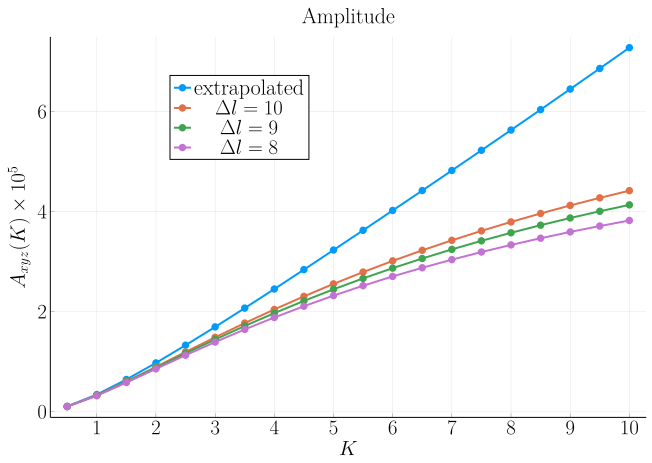

In [ ]:
plotib0= plot(0.5:0.5:10,
               [means_100K_1_extrapolation .* 10^5, means_100K_1_DL10 .* 10^5, means_100K_1_DL9 .* 10^5, means_100K_1_DL8 .* 10^5],
                label = ["extrapolated" L"\Delta l = 10"  L"\Delta l = 9"  L"\Delta l = 8"],
               xlabel = L"K",
               ylabel = L"A_{xyz}(K) \times 10^5",
               title = ["Amplitude "],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.2,0.9),
               )

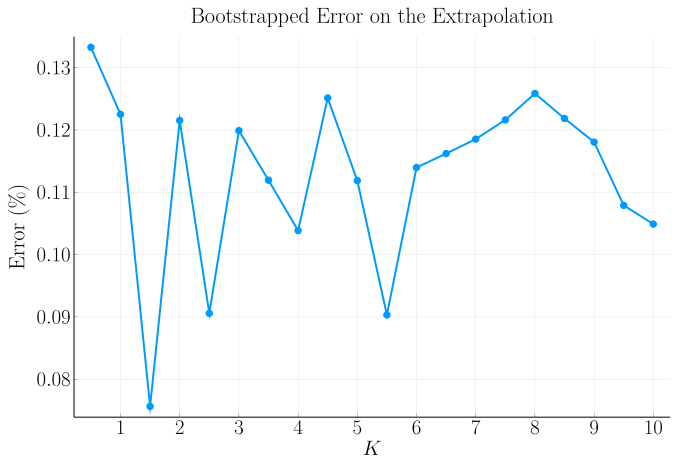

In [ ]:
error = plot(0.5:0.5:10,
               [stds_100K_1_P_extrapolation],
               label = ["std of averages"],
               title = ["Bootstrapped Error on the Extrapolation"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               xlabel = L"K",
               ylabel = "Error (%)",
               legend = false,
               )

We use the simplest possible fit Least Squares fit

In [ ]:
using LsqFit

We always fit with a function 
$$ c_2 K^{c_1} + c_3 K^{c_1-1} $$
note that this should capture the scaling only qualitatively. The full amplitude would behave as a general polynomial of order $c_1$. However adding too many terms would for sure overfit the data. Not enough terms will underfit the data failing to capture the complexity of the scaling.  

In [ ]:
function fit_scaling(data, scalingseed = 1.0)
    # Def of the model. The @. make it such it apply to the array term by term
    @. model(K, c) = c[2] * K^c[1] + c[3] * K^(c[1]-1)
    # general range for which we have the data
    cutoffs = 0.5:0.5:10
    # initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
    c0 = [scalingseed,1.0,1.0]
    # We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
    curve_fit(model, cutoffs[9:end], data[9:end], c0)
end

fit_scaling (generic function with 2 methods)

Let's fit the amplitude with $\mu = 1$ we know it should diverge as $K^9$. We start with the exact calculation.

In [ ]:
fit = fit_scaling(means_100K_1_extrapolation)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([1.0753243021847152, 6.5075049465720055e-6, -3.893355526947947e-6], [1.531349343027348e-8, -3.74182481914921e-10, -1.0178673565941205e-8, -1.831531146472172e-8, -6.51736248071655e-9, -6.464803347936755e-10, 4.1944617680539234e-9, 1.2428954629438525e-8, 1.4837122220606378e-8, 2.092223644158185e-9, 3.9271609559134515e-9, -1.6742012015329307e-8], [4.277034865291345e-5 5.039823074091849 1.1199606831315223; 5.2042707902888016e-5 5.644421431242473 1.1288842862484945; … ; 0.00015451342991177174 11.25563376429286 1.1848035541360897; 0.0001675565802472524 11.8939005316117 1.18939005316117], true, Float64[])

With CI 95% the scaling parameter has a HUGE compatible interval

In [ ]:
confidence_interval(fit)

3-element Vector{Tuple{Float64, Float64}}:
 (1.0699693392776075, 1.0806792650918229)
 (6.406993188813406e-6, 6.608016704330605e-6)
 (-4.156204347919559e-6, -3.6305067059763354e-6)

We interpret this as a sign of the fact that the LO and NLO of the divergence have contributes in a very similar way in the range of values we are considering for the function. Therefore it is very difficult for the numerical fit to distinguish among them. Making very hard to find the scaling exponent.  

This is also confirmed by the Huge convariance of the two coefficients.

In [ ]:
estimate_covar(fit)

3×3 Matrix{Float64}:
  5.6036e-6    -1.05091e-10   2.73163e-10
 -1.05091e-10   1.97419e-15  -5.14692e-15
  2.73163e-10  -5.14692e-15   1.3501e-14

# Study $\mu=1/3$

In [ ]:
amp_100K_13_DL10 , std_100K_13_DL10 = get_data_alltrials(100000,MU[1/3],0,10);
amp_100K_13_DL9  , std_100K_13_DL9  = get_data_alltrials(100000,MU[1/3],0,9);
amp_100K_13_DL8  , std_100K_13_DL8  = get_data_alltrials(100000,MU[1/3],0,8);

means_100K_13_DL10 = [mean(ampl) for ampl in eachrow(amp_100K_13_DL10)][2:end];
stds_100K_13_DL10  = [std(ampl)  for ampl in eachrow(amp_100K_13_DL10)][2:end];

means_100K_13_DL9 = [mean(ampl) for ampl in eachrow(amp_100K_13_DL9)][2:end];
stds_100K_13_DL9  = [std(ampl)  for ampl in eachrow(amp_100K_13_DL9)][2:end];

means_100K_13_DL8 = [mean(ampl) for ampl in eachrow(amp_100K_13_DL8)][2:end];
stds_100K_13_DL8  = [std(ampl)  for ampl in eachrow(amp_100K_13_DL8)][2:end];

amp_100K_13_extrapolation = DataFrame()
for trial in 1:10
    tmpdf = DataFrame([amp_100K_13_DL10[!,"trial$(trial)"],amp_100K_13_DL9[!,"trial$(trial)"],amp_100K_13_DL8[!,"trial$(trial)"]],["DL10","DL9","DL8"])
    amp_100K_13_extrapolation[!,"trial$(trial)"] = [extrapolate(ampl.DL10,ampl.DL9,ampl.DL8) for ampl in eachrow(tmpdf)];
end

means_100K_13_extrapolation = [mean(ampl) for ampl in eachrow(amp_100K_13_extrapolation)][2:end];
stds_100K_13_extrapolation  = [std(ampl)  for ampl in eachrow(amp_100K_13_extrapolation)][2:end];

stds_100K_13_P_extrapolation = 100*(stds_100K_13_extrapolation./means_100K_13_extrapolation);


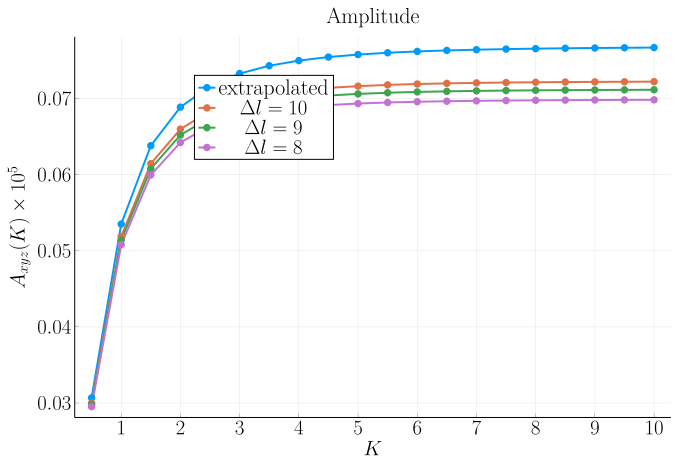

In [ ]:
plotib0= plot(0.5:0.5:10,
               [means_100K_13_extrapolation .* 10^5, means_100K_13_DL10 .* 10^5, means_100K_13_DL9 .* 10^5, means_100K_13_DL8 .* 10^5],
                label = ["extrapolated" L"\Delta l = 10"  L"\Delta l = 9"  L"\Delta l = 8"],
               xlabel = L"K",
               ylabel = L"A_{xyz}(K) \times 10^5",
               title = ["Amplitude "],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.2,0.9),
               )

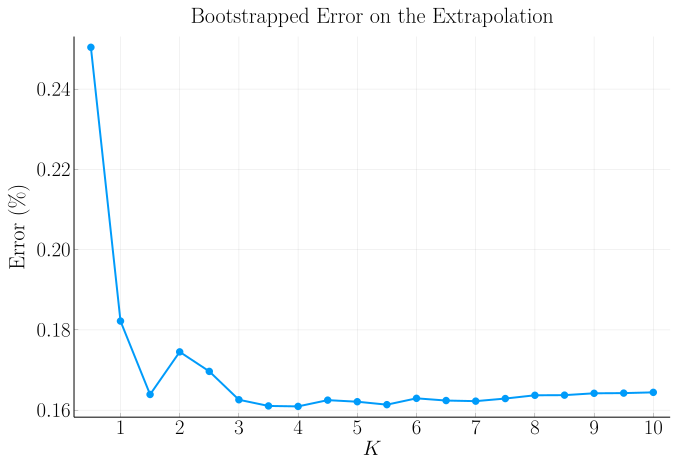

In [ ]:
error = plot(0.5:0.5:10,
               [stds_100K_13_P_extrapolation],
               label = ["std of averages"],
               title = ["Bootstrapped Error on the Extrapolation"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               xlabel = L"K",
               ylabel = "Error (%)",
               legend = false,
               )

We use the simplest possible fit Least Squares fit

In [ ]:
using LsqFit

We always fit with a function 
$$ c_2 K^{c_1} + c_3 K^{c_1-1} $$
note that this should capture the scaling only qualitatively. The full amplitude would behave as a general polynomial of order $c_1$. However adding too many terms would for sure overfit the data. Not enough terms will underfit the data failing to capture the complexity of the scaling.  

Let's fit the amplitude with $\mu = 1$ we know it should diverge as $K^9$. We start with the exact calculation.

In [ ]:
fit = fit_scaling(means_100K_13_extrapolation)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([-0.026657620091847346, 8.399261874104245e-7, -2.446765873053723e-7], [1.1311730799266419e-10, -6.210666669855235e-11, -1.0763259599022748e-10, -8.461074034372639e-11, -1.590687031184266e-11, 3.989105237296764e-11, 6.844251761737354e-11, 8.593532026466021e-11, 7.512387177284918e-11, 3.3464062797275745e-11, -2.934770966997938e-11, -1.1637396947198558e-10], [1.1350968640258817e-6 0.9606980495258638 0.21348845545019193; 1.2195870980191467e-6 0.9580035604904408 0.19160071209808816; … ; 1.726169761261763e-6 0.9417512722362137 0.09913171286696987; 1.7658749581816747e-6 0.9404644418746971 0.09404644418746973], true, Float64[])

With CI 95% the scaling parameter has a HUGE compatible interval

In [ ]:
confidence_interval(fit)

3-element Vector{Tuple{Float64, Float64}}:
 (-0.029161496809895448, -0.024153743373799243)
 (8.338854693380321e-7, 8.45966905482817e-7)
 (-2.59102076094209e-7, -2.302510985165356e-7)

We interpret this as a sign of the fact that the LO and NLO of the divergence have contributes in a very similar way in the range of values we are considering for the function. Therefore it is very difficult for the numerical fit to distinguish among them. Making very hard to find the scaling exponent.  

This is also confirmed by the Huge convariance of the two coefficients.

In [ ]:
estimate_covar(fit)

3×3 Matrix{Float64}:
  1.22512e-6   -2.95323e-12   7.01379e-12
 -2.95323e-12   7.13069e-18  -1.69823e-17
  7.01379e-12  -1.69823e-17   4.06645e-17

# Study $\mu=7/6$

In [117]:
amp_100K_76_DL10 , std_100K_76_DL10 = get_data_alltrials(100000,MU[7/6],0,10);
amp_100K_76_DL9  , std_100K_76_DL9  = get_data_alltrials(100000,MU[7/6],0,9);
amp_100K_76_DL8  , std_100K_76_DL8  = get_data_alltrials(100000,MU[7/6],0,8);

means_100K_76_DL10 = [mean(ampl) for ampl in eachrow(amp_100K_76_DL10)][2:end];
stds_100K_76_DL10  = [std(ampl)  for ampl in eachrow(amp_100K_76_DL10)][2:end];

means_100K_76_DL9 = [mean(ampl) for ampl in eachrow(amp_100K_76_DL9)][2:end];
stds_100K_76_DL9  = [std(ampl)  for ampl in eachrow(amp_100K_76_DL9)][2:end];

means_100K_76_DL8 = [mean(ampl) for ampl in eachrow(amp_100K_76_DL8)][2:end];
stds_100K_76_DL8  = [std(ampl)  for ampl in eachrow(amp_100K_76_DL8)][2:end];

amp_100K_76_extrapolation = DataFrame()
for trial in 1:10
    tmpdf = DataFrame([amp_100K_76_DL10[!,"trial$(trial)"],amp_100K_76_DL9[!,"trial$(trial)"],amp_100K_76_DL8[!,"trial$(trial)"]],["DL10","DL9","DL8"])
    amp_100K_76_extrapolation[!,"trial$(trial)"] = [extrapolate(ampl.DL10,ampl.DL9,ampl.DL8) for ampl in eachrow(tmpdf)];
end

means_100K_76_extrapolation = [mean(ampl) for ampl in eachrow(amp_100K_76_extrapolation)][2:end];
stds_100K_76_extrapolation  = [std(ampl)  for ampl in eachrow(amp_100K_76_extrapolation)][2:end];

stds_100K_76_P_extrapolation = 100*(stds_100K_76_extrapolation./means_100K_76_extrapolation);


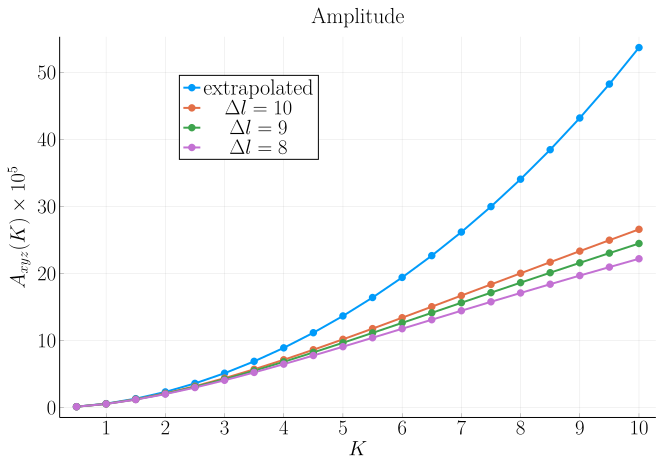

In [119]:
plotib0= plot(0.5:0.5:10,
               [means_100K_76_extrapolation .* 10^5, means_100K_76_DL10 .* 10^5, means_100K_76_DL9 .* 10^5, means_100K_76_DL8 .* 10^5],
                label = ["extrapolated" L"\Delta l = 10"  L"\Delta l = 9"  L"\Delta l = 8"],
               xlabel = L"K",
               ylabel = L"A_{xyz}(K) \times 10^5",
               title = ["Amplitude "],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.2,0.9),
               )

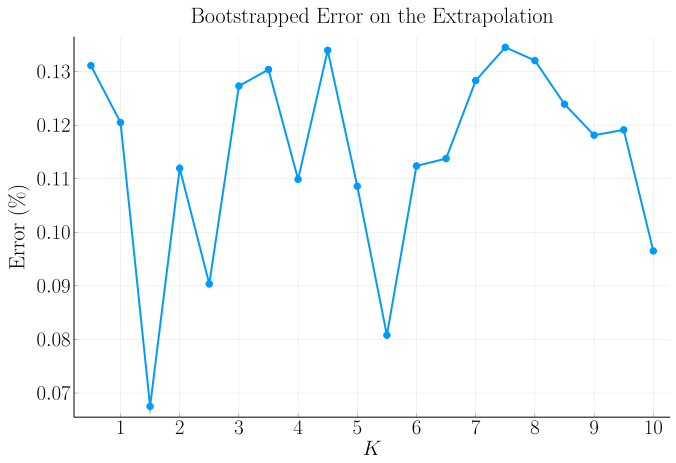

In [120]:
error = plot(0.5:0.5:10,
               [stds_100K_76_P_extrapolation],
               label = ["std of averages"],
               title = ["Bootstrapped Error on the Extrapolation"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               xlabel = L"K",
               ylabel = "Error (%)",
               legend = false,
               )

We use the simplest possible fit Least Squares fit

In [121]:
using LsqFit

We always fit with a function 
$$ c_2 K^{c_1} + c_3 K^{c_1-1} $$
note that this should capture the scaling only qualitatively. The full amplitude would behave as a general polynomial of order $c_1$. However adding too many terms would for sure overfit the data. Not enough terms will underfit the data failing to capture the complexity of the scaling.  

Let's fit the amplitude with $\mu = 1$ we know it should diverge as $K^9$. We start with the exact calculation.

In [122]:
fit = fit_scaling(means_100K_76_extrapolation)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([2.545674353239857, 7.788726561924621e-7, 7.479802957735829e-6], [4.906795367789693e-7, 9.479966636455513e-9, -3.077585382347018e-7, -4.656618052854356e-7, -3.7978740390529303e-7, -2.1229227101688146e-7, 5.313570096789934e-8, 3.4147463627987994e-7, 5.288571077957812e-7, 4.351953359425353e-7, 1.903385453752831e-7, -7.279395287206189e-7], [0.00016893257331395287 46.01149489349801 10.224776642999558; 0.00022027936116223598 60.16584405620875 12.033168811241747; … ; 0.0010870525883275887 308.2945919967175 32.452062315443946; 0.001235057721232471 351.2969289894235 35.12969289894236], true, Float64[])

With CI 95% the scaling parameter has a HUGE compatible interval

In [123]:
confidence_interval(fit)

3-element Vector{Tuple{Float64, Float64}}:
 (2.230921939270556, 2.860426767209158)
 (-2.7745574148905634e-7, 1.8352010538739806e-6)
 (6.961598055563937e-6, 7.99800785990772e-6)

We interpret this as a sign of the fact that the LO and NLO of the divergence have contributes in a very similar way in the range of values we are considering for the function. Therefore it is very difficult for the numerical fit to distinguish among them. Making very hard to find the scaling exponent.  

This is also confirmed by the Huge convariance of the two coefficients.

In [124]:
estimate_covar(fit)

3×3 Matrix{Float64}:
  0.0193594   -6.49691e-8   -3.15324e-8
 -6.49691e-8   2.18048e-13   1.05691e-13
 -3.15324e-8   1.05691e-13   5.24756e-14

# Study $\mu=8/6$

In [134]:
amp_100K_86_DL10 , std_100K_86_DL10 = get_data_alltrials(100000,MU[8/6],0,10);
amp_100K_86_DL9  , std_100K_86_DL9  = get_data_alltrials(100000,MU[8/6],0,9);
amp_100K_86_DL8  , std_100K_86_DL8  = get_data_alltrials(100000,MU[8/6],0,8);

means_100K_86_DL10 = [mean(ampl) for ampl in eachrow(amp_100K_86_DL10)][2:end];
stds_100K_86_DL10  = [std(ampl)  for ampl in eachrow(amp_100K_86_DL10)][2:end];

means_100K_86_DL9 = [mean(ampl) for ampl in eachrow(amp_100K_86_DL9)][2:end];
stds_100K_86_DL9  = [std(ampl)  for ampl in eachrow(amp_100K_86_DL9)][2:end];

means_100K_86_DL8 = [mean(ampl) for ampl in eachrow(amp_100K_86_DL8)][2:end];
stds_100K_86_DL8  = [std(ampl)  for ampl in eachrow(amp_100K_86_DL8)][2:end];

amp_100K_86_extrapolation = DataFrame()
for trial in 1:10
    tmpdf = DataFrame([amp_100K_86_DL10[!,"trial$(trial)"],amp_100K_86_DL9[!,"trial$(trial)"],amp_100K_86_DL8[!,"trial$(trial)"]],["DL10","DL9","DL8"])
    amp_100K_86_extrapolation[!,"trial$(trial)"] = [extrapolate(ampl.DL10,ampl.DL9,ampl.DL8) for ampl in eachrow(tmpdf)];
end

means_100K_86_extrapolation = [mean(ampl) for ampl in eachrow(amp_100K_86_extrapolation)][2:end];
stds_100K_86_extrapolation  = [std(ampl)  for ampl in eachrow(amp_100K_86_extrapolation)][2:end];

stds_100K_86_P_extrapolation = 100*(stds_100K_86_extrapolation./means_100K_86_extrapolation);


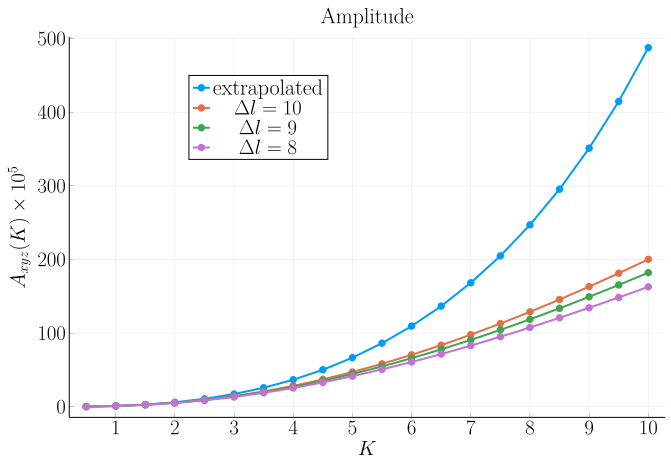

In [135]:
plotib0= plot(0.5:0.5:10,
               [means_100K_86_extrapolation .* 10^5, means_100K_86_DL10 .* 10^5, means_100K_86_DL9 .* 10^5, means_100K_86_DL8 .* 10^5],
                label = ["extrapolated" L"\Delta l = 10"  L"\Delta l = 9"  L"\Delta l = 8"],
               xlabel = L"K",
               ylabel = L"A_{xyz}(K) \times 10^5",
               title = ["Amplitude "],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.2,0.9),
               )

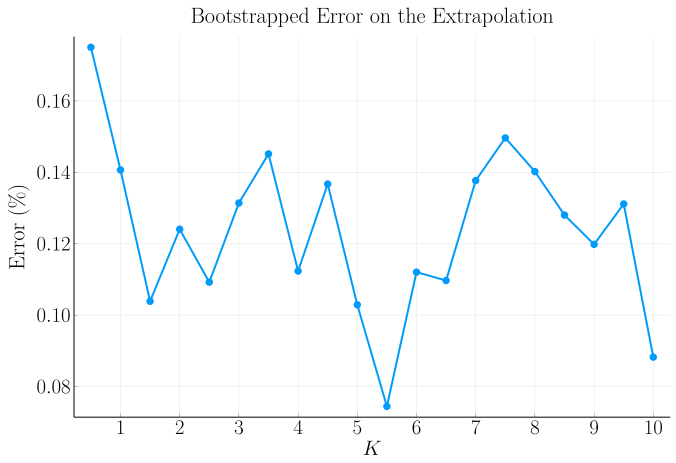

In [136]:
error = plot(0.5:0.5:10,
               [stds_100K_86_P_extrapolation],
               label = ["std of averages"],
               title = ["Bootstrapped Error on the Extrapolation"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               xlabel = L"K",
               ylabel = "Error (%)",
               legend = false,
               )

We use the simplest possible fit Least Squares fit

In [129]:
using LsqFit

We always fit with a function 
$$ c_2 K^{c_1} + c_3 K^{c_1-1} $$
note that this should capture the scaling only qualitatively. The full amplitude would behave as a general polynomial of order $c_1$. However adding too many terms would for sure overfit the data. Not enough terms will underfit the data failing to capture the complexity of the scaling.  

Let's fit the amplitude with $\mu = 1$ we know it should diverge as $K^9$. We start with the exact calculation.

In [137]:
fit = fit_scaling(means_100K_86_extrapolation)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([-33.267935304358474, -1.6622850108168066, 8.8810261994741], [-0.0005024718359816435, -0.0006667549804796126, -0.0008632426520355854, -0.0010954371806925483, -0.0013670283819802258, -0.0016833173603591832, -0.002048968169363023, -0.0024703894147428914, -0.0029547637706909173, -0.0035108801082569243, -0.004146292781962374, -0.004876087205973894], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], true, Float64[])

With CI 95% the scaling parameter has a HUGE compatible interval

In [138]:
confidence_interval(fit)

LoadError: LinearAlgebra.LAPACKException(1)

We interpret this as a sign of the fact that the LO and NLO of the divergence have contributes in a very similar way in the range of values we are considering for the function. Therefore it is very difficult for the numerical fit to distinguish among them. Making very hard to find the scaling exponent.  

This is also confirmed by the Huge convariance of the two coefficients.

In [139]:
estimate_covar(fit)

LoadError: LinearAlgebra.LAPACKException(1)